In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import torch.optim as optim

In [58]:
transforms = transforms.ToTensor()

In [59]:
train_data = datasets.MNIST("FashionMNIST/",train=True,download=True,transform=transforms)
test_data = datasets.MNIST("FashionMNIST/",train=False,download=True,transform=transforms)

In [60]:
val_size = 0.2
num_workers = 0
batch_size = 20

In [61]:
num_samples = len(train_data)
idx = list(range(num_samples))
np.random.shuffle(idx)
samples = int(np.floor(num_samples*val_size))
train_idx, val_idx = idx[samples:], idx[:samples]

In [62]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

In [63]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

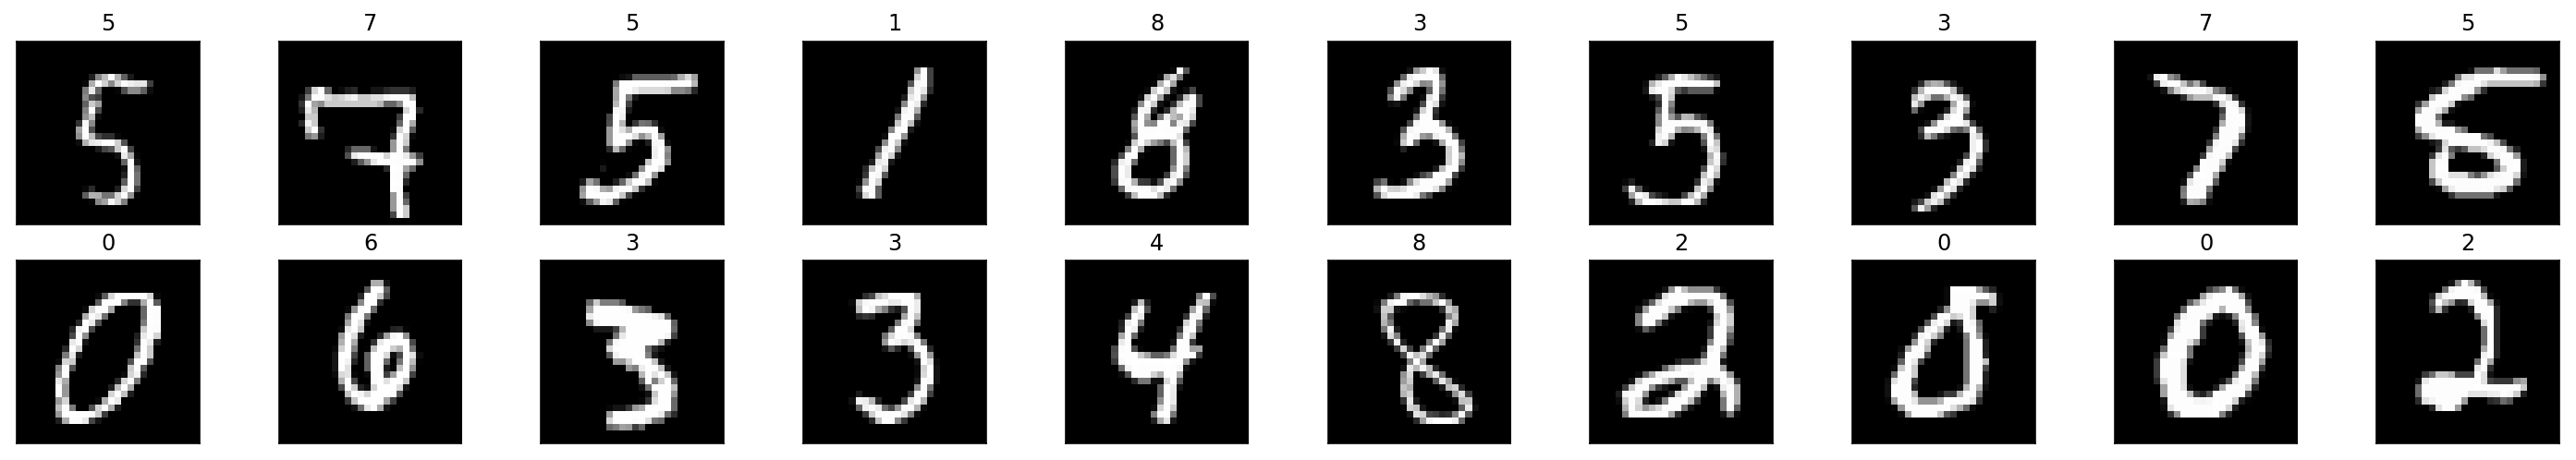

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

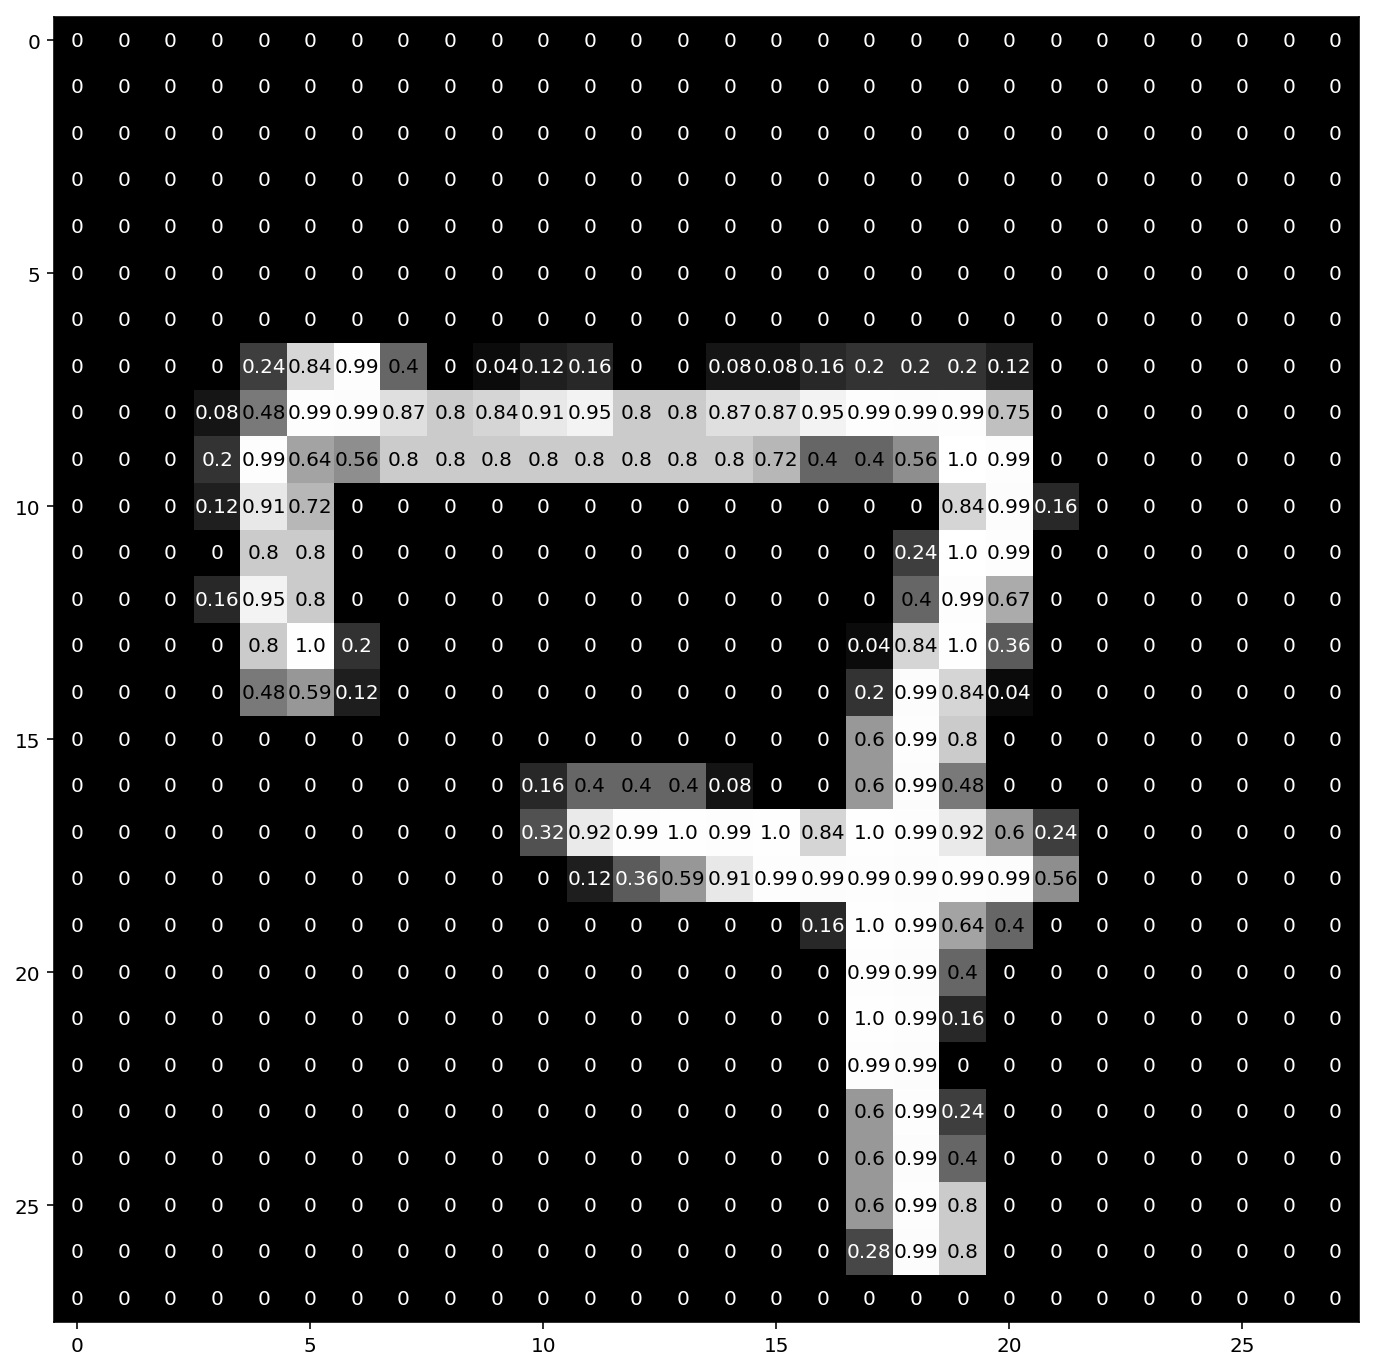

In [65]:
img = np.squeeze(images[1])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray',interpolation='nearest')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y].item(),2) if img[x][y]!=0 else 0
        ax.annotate(str(val),xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')

In [67]:
model = nn.Sequential(nn.Linear(784,256),
                     nn.ReLU(),
                     nn.Linear(256,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.Dropout(0.2),
                     nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(),0.001)

In [68]:
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): Dropout(p=0.2)
  (8): LogSoftmax()
)

In [89]:
n_epochs = 5
valid_loss_min = np.Inf

for idx in range(1,n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        images = images.reshape(images.shape[0],-1)
        output = model(images)
        
        loss = criterion(output,labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
    model.eval()
    for images, labels in valid_loader:
        
        output = model(images.reshape(images.shape[0],-1))
        
        loss = criterion(output,labels)
        
        valid_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = train_loss/len(test_loader.dataset)
    
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(idx+1,train_loss,test_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        

Epoch: 2 	Training Loss: 0.011541 	Validation Loss: 0.000001
Validation loss decreased (inf --> 1709.697889).  Saving model ...
Epoch: 3 	Training Loss: 0.010343 	Validation Loss: 0.000001
Validation loss decreased (1709.697889 --> 1503.887222).  Saving model ...
Epoch: 4 	Training Loss: 0.010847 	Validation Loss: 0.000001
Epoch: 5 	Training Loss: 0.010147 	Validation Loss: 0.000001
Epoch: 6 	Training Loss: 0.009160 	Validation Loss: 0.000001


In [91]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    data = data.reshape(data.shape[0],-1)
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)
    
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.152946

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 98% (1121/1135)
Test Accuracy of     2: 97% (1005/1032)
Test Accuracy of     3: 99% (1000/1010)
Test Accuracy of     4: 97% (953/982)
Test Accuracy of     5: 95% (850/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 96% (976/1009)

Test Accuracy (Overall): 97% (9760/10000)
